In [1]:
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft')
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift, ifft,fft2,ifft2
import sys
from tqdm import tqdm # for progress bars
from statistics import mean, stdev
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px
# Repositorio
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft') 
import torch
import frft
import frft_gpu as frft_g
import time
from Deep_Utils import dbscale
from PyEMD import EMD
from scipy.signal import hilbert
from tqdm import tqdm

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

In [144]:
path = r'E:\DLOCT\Experimental_Data_complex'
file = 'depthNail.npy'
filecc = 'depthNailcc.npy'
tom = np.load(os.path.join(path,file))
tomcc = np.load(os.path.join(path,filecc))

In [145]:
fringescc = fftshift(ifft(tomcc[:,:,:,0]+1j*tomcc[:,:,:,1],axis=0),axes=0)
fringes = fftshift(ifft(tom[:,:,:,0]+1j*tom[:,:,:,1],axis=0),axes=0)
aline = 512
bscan = 0
singlecc = fringescc[:,aline,bscan]
single = fringes[:,aline,bscan]

In [146]:
fig = make_subplots(rows=3, cols=1)
fig.add_trace(
    go.Scatter(y=np.real(singlecc), mode='lines', name='artifacts fringes'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=np.real(single), mode='lines', name='no artifacts real part'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=np.imag(single), mode='lines', name='no artifacts image part'),
    row=3, col=1
)
fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="artifacts fringes", row=1, col=1)
fig.update_xaxes(title_text="no artifacts real part", row=2, col=1)
fig.update_xaxes(title_text="no artifacts image part", row=3, col=1)
fig.show()

In [147]:
emd = EMD()
imfs_real = emd(np.real(single))
imfs_imag = emd(np.imag(single))
imfscc_real = emd(np.real(singlecc))
imfscc_imag = emd(np.imag(singlecc))

In [148]:
imfs_real.shape[1]

1024

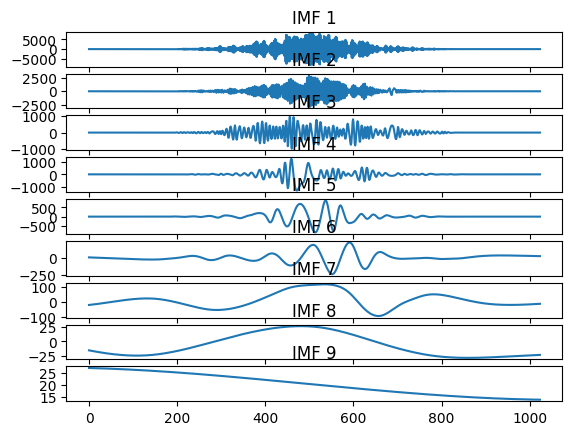

In [149]:

plt.figure()
for i in range(len(imfs_real)):
    plt.subplot(len(imfs_real), 1, i+1)
    plt.plot(imfs_real[i])
    plt.title(f'IMF {i+1}')
plt.show()

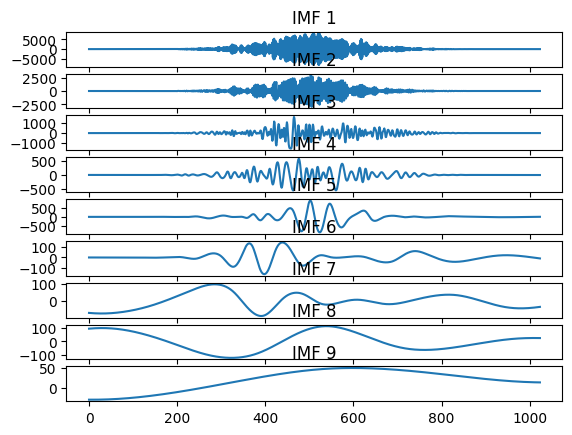

In [150]:
plt.figure()
for i in range(len(imfs_imag)):
    plt.subplot(len(imfs_imag), 1, i+1)
    plt.plot(imfs_imag[i])
    plt.title(f'IMF {i+1}')
plt.show()

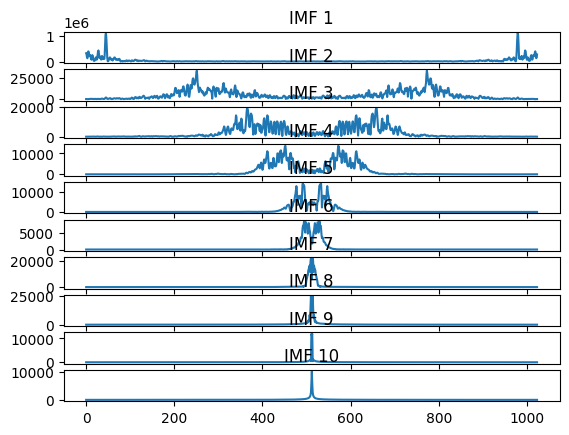

24988294.239476603
25759762.099758822


In [151]:
powerleft = 0
powerright = 0
plt.figure()
for i in range(len(imfscc_real)):
    fftimf = fftshift(fft(imfscc_real[i]))
    left = abs(np.sum(fftimf[0:int(len(fftimf)/2)]))**2/len(fftimf)/2
    right = abs(np.sum(fftimf[int(len(fftimf)/2):]))**2/len(fftimf)/2
    powerleft += left
    powerright += right
    plt.subplot(len(imfscc_real), 1, i+1)
    plt.plot(abs(fftimf))
    plt.title(f'IMF {i+1}')
plt.show()
print(powerleft)
print(powerright)

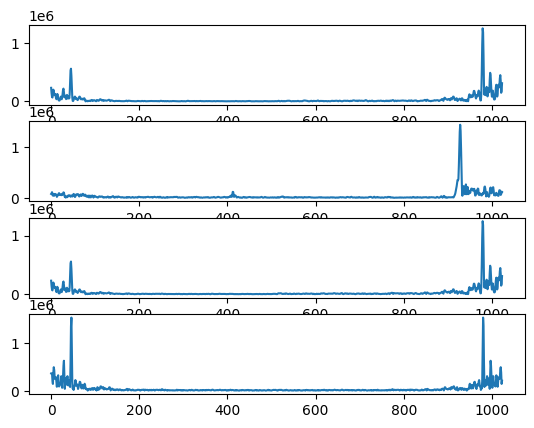

In [152]:
n=0
imf = (imfscc_real[n]+1j*hilbert(imfscc_real[n]))/2
analytic_signal = (np.real(singlecc) + 1j*hilbert(np.real(singlecc)))/2
fig, axs = plt.subplots(nrows =4,ncols = 1)
axs[0].plot((abs(fftshift(fft(imf)))))
axs[1].plot(abs(fftshift(fft(single))))
axs[2].plot((abs(fftshift(fft(analytic_signal)))))
axs[3].plot(abs(fftshift(fft(singlecc))))

In [153]:
nbscan = 0
bscancc = fringescc[:,:,nbscan]
bscan = fringes[:,:,nbscan]
def emd_bscan(bscan):
    imfs = []
    for i in tqdm(range(bscan.shape[1])):
        real_imfs = emd(bscan[:,i].real)
        imag_imfs = emd(bscan[:,i].imag)
        real_imfs = real_imfs[0:6,:]
        imag_imfs = imag_imfs[0:6,:]
        imfs_complex = real_imfs + 1j*imag_imfs
        imfs.append(imfs_complex)
    imfs = np.array(imfs)
    imfs = np.transpose(imfs,(2,0,1))
    return imfs

imfs = emd_bscan(bscan)
imfscc = emd_bscan(bscancc)

100%|██████████| 1024/1024 [03:48<00:00,  4.47it/s]


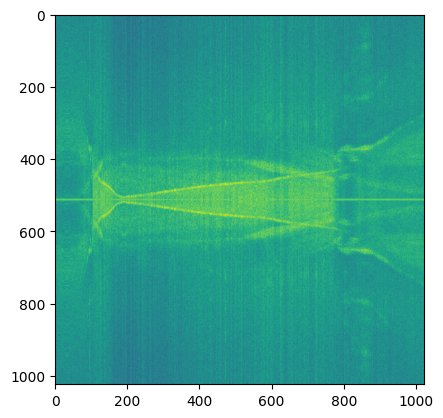

In [170]:
plt.imshow(dbscale((fft(imfscc[:,:,0],axis=0))))
# plt.imshow(dbscale((fft(bscancc,axis=0))))
# emd()

In [80]:
def Correlation(slices):
    slices = slices[:,:,0] + 1j*slices[:,:,1]
    
    correlationx = np.angle(slices[:,1:] * np.conjugate(slices[:,:-1]))
    correlationy = np.angle(slices[1:, :] * np.conjugate(slices[:-1, :]))
    stdx = np.std(correlationx)
    meanx = np.mean(correlationx)
    
    stdy = np.std(correlationy)
    meany = np.mean(correlationy)
    return correlationx,correlationy

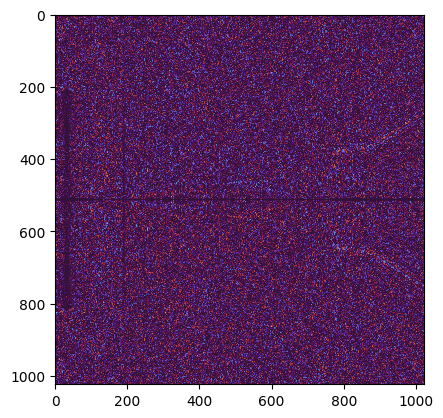

In [179]:
nbscan = 0
nimfs = 0
nimfsfft = fft(imfs[:,:,nimfs],axis=0)
imfsrec = np.stack((nimfsfft.real,nimfsfft.imag),axis=2)
nimfsfftcc = fft(imfscc[:,:,nimfs],axis=0)
imfsreccc = np.stack((nimfsfft.real,nimfsfft.imag),axis=2)
bscancc = fft(fringescc[:,:,nbscan],axis=0)
bscan = fft(fringes[:,:,nbscan],axis=0)
bscan = np.stack((bscan.real,bscan.imag),axis=2)
bscancc = np.stack((bscancc.real,bscancc.imag),axis=2)
corrx,corry = Correlation(bscancc)
plt.imshow(corrx,cmap='twilight',vmin=-3,vmax=3)

0.0


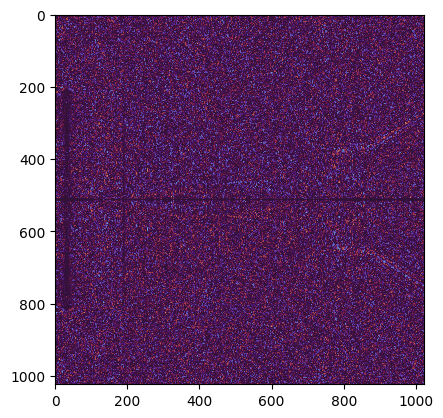

In [182]:
img_normalizada = (corrx + np.pi) / (2 * np.pi)
print(np.min(img_normalizada))
plt.imshow(img_normalizada,cmap='twilight')